In [1]:
'''
    Rebuild aggregate vectors with standard comparable polygons (something wrong here in general though must resolve workstream): 
        I: Start process from tesselation shape
        II: Intersect remote sensing input layers
        III: Intersect points and polygons
        IV: This is actually a more generic process that will wake in datasets and polygons and match them all up
        V: This script has to be run with system python at the moment
'''

import numpy as np 
import pandas as pd 

import matplotlib
import matplotlib.pyplot as plt

import rasterio
import shapefile as shp
from rasterio.plot import show
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np

from shapely import geometry
from shapely.geometry.polygon import LinearRing, Polygon
from shapely.geometry import Polygon, mapping
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import shape, Point
from descartes import PolygonPatch
import warnings
warnings.filterwarnings(action='ignore')


In [9]:

# tesselation shapefile
roi_path = "../data/18_22_100e_som_voronoi/18_22_100e_som_voronoi.shp"
ROI_shp=gpd.read_file(roi_path)
ROI_shp["Name"]= ['Feature_'+str(x) for x in range(0, len(ROI_shp))]
ROI=shp.Reader(roi_path)


# remote sensing inputs
ndb_path = "../data/ND_built_up/ndbi_ROI.tif"
ndb_dat = rasterio.open(ndb_path)
imp_path = "/Users/culhane/Desktop/wgs-50s-imp.tif"
imp_dat = rasterio.open(imp_path)
imp2_path = "../data/impervious_surface/50T_gmis_impervious_surface_percentage_utm_30m.tif"
imp2_dat = rasterio.open(imp2_path)
nl13_path = "../data/night_lights/NL_ROI_2013.tif"
nl13_dat = rasterio.open(nl13_path)

# social media inputs
df_weibo = pd.read_csv('../data/inLabelRegionPoints.csv')

# rectangular grid polygons
roi_pathr = "../data/regular_grid_shape/regular_grid_shape.shp"
ROI_shpr=gpd.read_file(roi_pathr)
ROI_shpr["Name"]= ['Feature_'+str(x) for x in range(0, len(ROI_shpr))]
ROIr=shp.Reader(roi_pathr)


In [10]:
# user defined functions

def getInPolyPoints(poly, df): 
    bounds = poly.bounds
    d = df.loc[(df['lat'] >= bounds[1]) & (df['lat'] <= bounds[3]) \
        & (df['lon'] >= bounds[0]) & (df['lon'] <= bounds[2])]
    d['labelInPoly'] = d.apply(lambda row: labelInPoly(row), axis=1)
    return d.loc[d['labelInPoly'] == 'in']

def labelInPoly(row): 
    point = Point(row['lon'], row['lat'])
    out = 'out'
    if poly.contains(point):
            out = 'in'
    return out


In [11]:
# intersect remote sensing indices with polygons from tesselation

res_ndb = zonal_stats(roi_path, ndb_path, nodata=-999,
            stats="mean")
res_imp = zonal_stats(roi_path, imp_path, nodata=-999,
            stats="mean")
res_nl = zonal_stats(roi_path, nl13_path, nodata=-999,
            stats="mean")
ndb_list = zonal_stats(roi_path, ndb_path, categorical=True, nodata=-999)[1]
imp_list = zonal_stats(roi_path, imp_path, categorical=True, nodata=-999)[1]
nl13_list = zonal_stats(roi_path, nl13_path, categorical=True, nodata=-999)[1]

/Users/culhane/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


In [12]:
# intersect remote sensing inputs with rectangular grid 

res_ndbr = zonal_stats(roi_pathr, ndb_path, nodata=-999,
            stats="mean")
res_impr = zonal_stats(roi_pathr, imp_path, nodata=-999,
            stats="mean")
res_nlr = zonal_stats(roi_pathr, nl13_path, nodata=-999,
            stats="mean")
ndb_listr = zonal_stats(roi_pathr, ndb_path, categorical=True, nodata=-999)[1]
imp_listr = zonal_stats(roi_pathr, imp_path, categorical=True, nodata=-999)[1]
nl13_listr = zonal_stats(roi_pathr, nl13_path, categorical=True, nodata=-999)[1]

In [20]:
# get corners of ROI to specify plotting window
maxLon, minLon = np.max(df_weibo['lon']), np.min(df_weibo['lon'])
maxLat, minLat = np.max(df_weibo['lat']), np.min(df_weibo['lat'])
corners = [(minLon, maxLat), (maxLon, maxLat), (maxLon, minLat), (minLon, minLat)]
dfCorners = pd.DataFrame(corners)
dfCorners.columns = ['lon', 'lat']


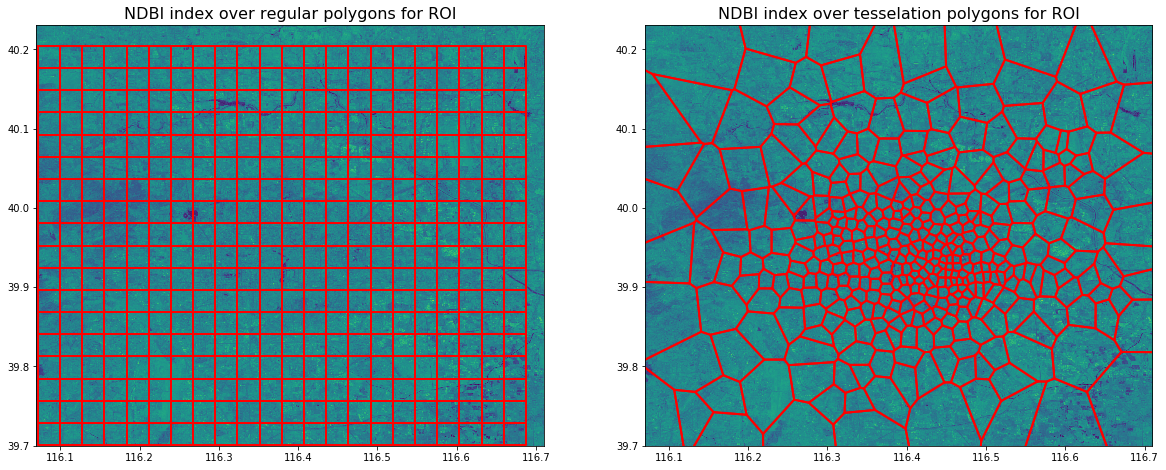

In [31]:
# plot NDBI
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,20))
for shape in ROIr.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax1.plot(x,y, color='red', linewidth=2)

show((ndb_dat, 1), ax=ax1)
   
    
for shape in ROI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax2.plot(x,y, color='red', linewidth=2)
    
show((ndb_dat, 1), ax=ax2) 
ax1.set_title('NDBI index over regular polygons for ROI', fontsize=16)
ax2.set_title('NDBI index over tesselation polygons for ROI', fontsize=16)
plt.show()  
    

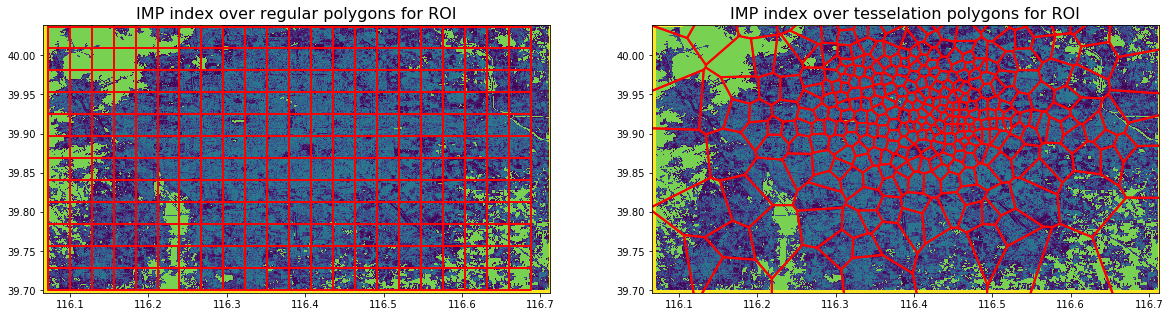

In [33]:
# plot impervious surface data over polygons 
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,20))
for shape in ROIr.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax1.plot(x,y, color='red', linewidth=2)
    # ax1.set_xlim(minLon, maxLon)
    # ax1.set_ylim(minLat, maxLat)
    
show((imp_dat, 1), ax=ax1)
   
    
for shape in ROI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax2.plot(x,y, color='red', linewidth=2)
    # limit axes to ROI 
    # ax2.set_xlim(minLon, maxLon)
    # ax2.set_ylim(minLat, maxLat)
    
    
show((imp_dat, 1), ax=ax2) 
ax1.set_title('IMP index over regular polygons for ROI', fontsize=16)
ax2.set_title('IMP index over tesselation polygons for ROI', fontsize=16)
plt.show()  
    

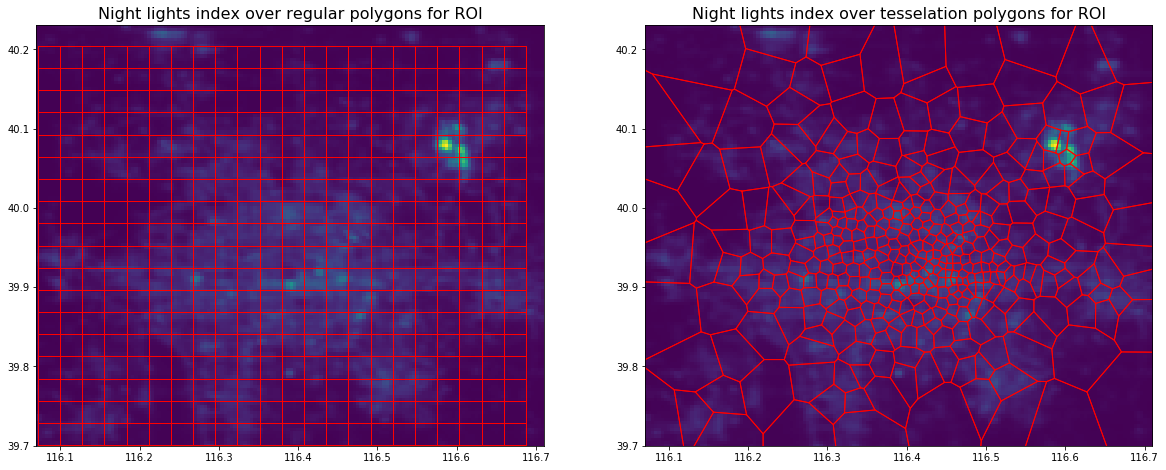

In [37]:
# plot night lights data over polygons 
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,20))
for shape in ROIr.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax1.plot(x,y, color='red', linewidth=1)
    # ax1.set_xlim(minLon, maxLon)
    # ax1.set_ylim(minLat, maxLat)
    
show((nl13_dat, 1), ax=ax1)
   
    
for shape in ROI.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax2.plot(x,y, color='red', linewidth=1)
    # limit axes to ROI 
    # ax2.set_xlim(minLon, maxLon)
    # ax2.set_ylim(minLat, maxLat)
    
    
show((nl13_dat, 1), ax=ax2) 
ax1.set_title('Night lights index over regular polygons for ROI', fontsize=16)
ax2.set_title('Night lights index over tesselation polygons for ROI', fontsize=16)
plt.show()

In [38]:
# join mean values and dictionaries to polygons 

polygon_metrics = []
for i in range(0, len(ROI.shapeRecords())):
    shape = ROI.shapeRecords()[i]
    polygon = shape.shape.points[:]
    out = {
        'polygon' : polygon, 
        'mean_ndb' : res_ndb[i]['mean'], 
        'mean_imp' : res_imp[i]['mean'], 
        'mean_nl' : res_nl[i]['mean'],
        'list_ndb' : ndb_list, 
        'list_imp' : imp_list,
        'list_nl' : nl13_list
    }
    polygon_metrics.append(out)

df_polygon = pd.DataFrame(polygon_metrics)
df_polygon.reset_index(inplace=True)
df_polygon.columns = [u'polygon_id', u'list_imp', u'list_ndb', u'list_nl', u'mean_imp',
       u'mean_ndb', u'mean_nl', u'polygon']

In [39]:
# place weibo points in polygons with same id numbers from above

dfTemp = df_weibo
inpolys = []
for p in range(len(df_polygon)):
    try: 
        polyRow = df_polygon.iloc[p]
        poly = polyRow['polygon']
        label = polyRow['polygon_id']
        poly = geometry.Polygon(poly)
        polypoints = getInPolyPoints(poly, dfTemp)
        polypoints['polygon_id'] = polypoints.apply(lambda row: label, axis=1)
        polypoints['polygon'] = polypoints.apply(lambda row: poly, axis=1)
        dfTemp = dfTemp.iloc[~dfTemp.index.isin(polypoints.index.tolist())]
        inpolys.append(polypoints)
    except: 
        print('error on polygon_id ' + str(p))

df_weibo_poly = pd.concat(inpolys)

/Users/culhane/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [52]:
# peak at data from intersection with tesselation polygons
df_weibo_poly.drop('Unnamed: 0', axis=1, inplace=True)
df_weibo_poly.head() 

,index,unID,lon,lat,timestamp,labelInPoly,polygon_id,polygon
36104,24520,"""0101000020E6100000D769A4A5F2085D409A7CB3CD8D1...",116.139810,40.137140,"""2012-01-16 19:25:59""",in,0,"POLYGON ((116.1443161833788 40.08063706900705,..."
36112,31482,"""0101000020E610000050214F79110A5D40A189C97E0A1...",116.157317,40.125320,"""2012-01-18 17:26:00""",in,0,"POLYGON ((116.1443161833788 40.08063706900705,..."
36113,31483,"""0101000020E61000006DBF4207190A5D4052BB3EF70E1...",116.157778,40.125457,"""2012-01-18 17:23:35""",in,0,"POLYGON ((116.1443161833788 40.08063706900705,..."
36417,244103,"""0101000020E6100000B4024356B7085D40F5D89601671...",116.136190,40.135956,"""2012-03-25 19:34:40""",in,0,"POLYGON ((116.1443161833788 40.08063706900705,..."
36453,263630,"""0101000020E61000007A6CCB80B3085D4059315C1D001...",116.135956,40.132816,"""2012-03-30 12:52:01""",in,0,"POLYGON ((116.1443161833788 40.08063706900705,..."


In [53]:
# write out intersection of RS and SM data with tesselation polygons
df_weibo_out = df_weibo_poly[['unID', 'lon', 'lat', 'timestamp', 'labelInPoly', 'polygon_id', 'polygon']]
df_weibo_out.to_csv('../data/social-media-with-polygon-labels-18-22-100e-som-voronoi.csv', index=False)
df_polygon.to_csv('../data/remote-sensing-layers-with-polygon-labels-18-22-100e-som-voronoi.csv', index=False)

In [54]:
# intersect RS and SM data with rectangular grid polygons 
polygon_metrics = []
for i in range(0, len(ROIr.shapeRecords())):
    shape = ROIr.shapeRecords()[i]
    polygon = shape.shape.points[:]
    out = {
        'polygon' : polygon, 
        'mean_ndb' : res_ndbr[i]['mean'], 
        'mean_imp' : res_impr[i]['mean'], 
        'mean_nl' : res_nlr[i]['mean'],
        'list_ndb' : ndb_listr, 
        'list_imp' : imp_listr,
        'list_nl' : nl13_listr
    }
    polygon_metrics.append(out)

df_polygon = pd.DataFrame(polygon_metrics)
df_polygon.reset_index(inplace=True)
df_polygon.columns = [u'polygon_id', u'list_imp', u'list_ndb', u'list_nl', u'mean_imp',
       u'mean_ndb', u'mean_nl', u'polygon']

# place weibo points in polygons with same id numbers from above
dfTemp = df_weibo
inpolys = []
for p in range(len(df_polygon)):
    try: 
        polyRow = df_polygon.iloc[p]
        poly = polyRow['polygon']
        label = polyRow['polygon_id']
        poly = geometry.Polygon(poly)
        polypoints = getInPolyPoints(poly, dfTemp)
        polypoints['polygon_id'] = polypoints.apply(lambda row: label, axis=1)
        polypoints['polygon'] = polypoints.apply(lambda row: poly, axis=1)
        dfTemp = dfTemp.iloc[~dfTemp.index.isin(polypoints.index.tolist())]
        inpolys.append(polypoints)
    except: 
        print('error on polygon_id ' + str(p))

df_weibo_poly = pd.concat(inpolys)

/Users/culhane/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


error on polygon_id 4
error on polygon_id 5
error on polygon_id 16
error on polygon_id 28
error on polygon_id 40
error on polygon_id 65
error on polygon_id 90
error on polygon_id 270
error on polygon_id 344


In [55]:
# peak at data from intersection with tesselation polygons
df_weibo_poly.drop('Unnamed: 0', axis=1, inplace=True)
df_weibo_poly.head() 

,index,unID,lon,lat,timestamp,labelInPoly,polygon_id,polygon
42,74546,"""0101000020E6100000226C787AA5045D4034F44F70B1D...",116.072600,39.708540,"""2012-01-26 11:30:57""",in,0,"POLYGON ((116.071601 39.72847299999999, 116.09..."
54,85464,"""0101000020E61000002DB29DEFA7045D402592E86514D...",116.072750,39.711560,"""2012-01-27 15:32:07""",in,0,"POLYGON ((116.071601 39.72847299999999, 116.09..."
316,568954,"""0101000020E6100000A038807EDF055D40D82B2CB81FD...",116.091766,39.719718,"""2012-06-24 20:47:17""",in,0,"POLYGON ((116.071601 39.72847299999999, 116.09..."
340,631566,"""0101000020E6100000DAE55B1FD6045D40B97020240BD...",116.075569,39.719090,"""2012-06-27 14:21:34""",in,0,"POLYGON ((116.071601 39.72847299999999, 116.09..."
395,762927,"""0101000020E610000073D9E89C9F045D40ED6305BF0DD...",116.072242,39.711357,"""2012-07-11 18:19:22""",in,0,"POLYGON ((116.071601 39.72847299999999, 116.09..."


In [56]:
# write out intersection RS and SM data with rectangular polygons to file
df_weibo_out = df_weibo_poly[['unID', 'lon', 'lat', 'timestamp', 'labelInPoly', 'polygon_id', 'polygon']]
df_weibo_out.to_csv('../data/social-media-data-with-polygon-rectangular-grid.csv', index=False)
df_polygon.to_csv('../data/remote-sensing-data-with-polygon-labels-rectangular-grid.csv', index=False)
